In [4]:
from smr import File
import numpy as np
from matplotlib import pyplot as plt
from kaveh.plots import axvlines
from kaveh.sorting.spikesorter import SimpleSpikeSorter


In [5]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [6]:
# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091608/B091608_1218_Adapt.smr'
# f_name = '/mnt/data/kkarbasi/SimpleSpike-Felix/Felix 2006.09.06/Felix 2006.09.06 1313 List.smr'
f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Step/S38/error_magnitude/S38_1_315degErrorTest.smr'
# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Wyatt/W120308_2/W120308_2_1714_List.smr'

In [7]:
smr_content = File(f_name)
smr_content.read_channels()

Not implemented (type = 6)
Not implemented (type = 5)


In [8]:
voltage_chan = smr_content.get_channel(0)
# HE_chan = smr_content.get_channel(1)
# VE_chan = smr_content.get_channel(2)

<IPython.core.display.Javascript object>


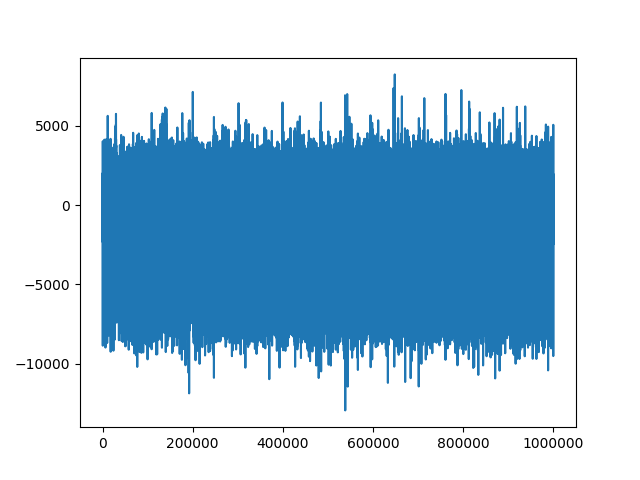

In [9]:
t_0 = 0 #s
t_end = 20 #s

idx_0 = int(np.round(t_0 / voltage_chan.dt))
idx_end = int(np.round(t_end / voltage_chan.dt))
prange = slice(idx_0, idx_end)
plt.plot(voltage_chan.data[prange])

In [10]:
%%time
# Time range of data to process:
t_0 = 0 #s
t_end = 20 #s

idx_0 = int(np.round(t_0 / voltage_chan.dt))
idx_end = int(np.round(t_end / voltage_chan.dt))
prange = slice(idx_0, idx_end)
sss = SimpleSpikeSorter(voltage_chan.data, voltage_chan.dt)
sss.run()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 64291 but corresponding boolean dimension is 64290

In [ ]:
sss.plot_voltage(figsize=(20,5))

In [ ]:
plt.savefig('raw_voltage_CS_full_zoom.png')

In [ ]:
axvlines(plt.gca(), sss.get_cs_spike_indices() * sss.dt, color='r', alpha=0.25, zorder=10)


In [ ]:
# sss.plot_spike_peaks()
sss.plot_spike_waveforms_average()
sss.recluster_complex_spikes(freq_range= (0,5000), gmm_nc=2, cov_type='diag', plot_hist=True)

sss.plot_voltage(figsize=(20,5))
axvlines(plt.gca(), sss.get_cs_spike_indices() * sss.dt, color='r', alpha=0.25, zorder=10)


In [10]:
max_powers, powers, xf = sss._find_max_powers()

In [ ]:
print(sss.aligned_spikes.shape)
print(powers.shape)
print(max_powers.shape)
print(xf.shape)


In [12]:
from kaveh.toolbox import closest_argmin
csi = sss.get_cs_spike_indices()
si = sss.get_spike_indices()
ssi = np.setdiff1d(si, csi)
cs = closest_argmin(csi, si)
ss = closest_argmin(ssi, si)

In [ ]:
cs.shape

In [ ]:
def plot_shaded_err(x, mean_signal, err_signal, **kw):
    """
    Plots the average spike wavelets of the current dataset
    """
    l = plt.plot(x, mean_signal, **kw)
    plt.fill_between(x, mean_signal - err_signal, mean_signal + err_signal, color=l[0].get_color(), alpha=0.25) 
    

plt.figure()
plot_shaded_err(xf, np.mean(powers[cs,:], axis=0), np.std(powers[cs,:], axis=0)/np.sqrt(cs.size))
plot_shaded_err(xf, np.mean(powers[ss,:], axis=0), np.std(powers[ss,:], axis=0)/np.sqrt(ssi.size))

In [ ]:
plt.figure()

plt.plot(xf, powers[35,:])
plt.plot(xf, powers[2,:])

plt.xlabel('Frequency (Hz)')
plt.ylabel('Signal Power')
plt.legend(['CS', 'SS'])
plt.savefig('test.png')

<IPython.core.display.Javascript object>


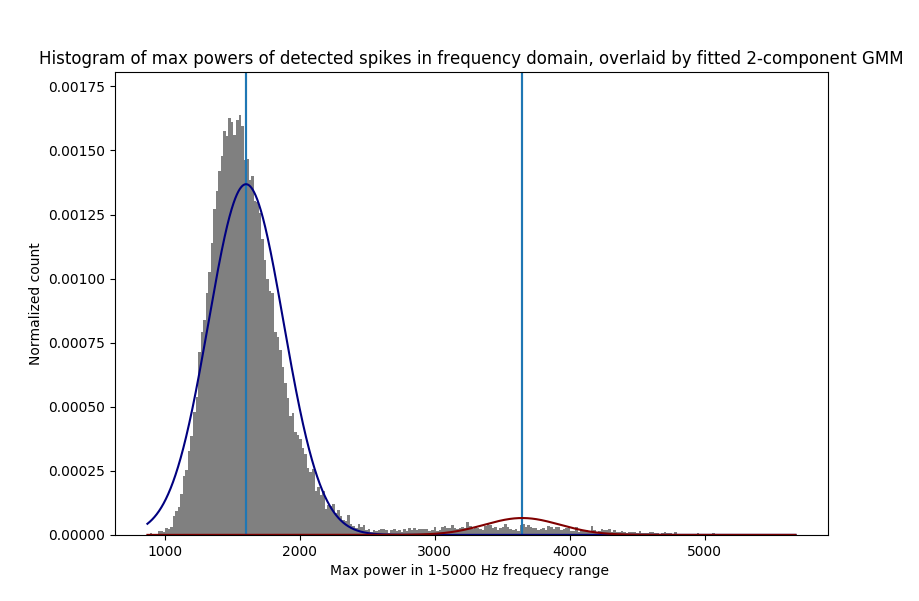

In [35]:
# Spike window (in seconds)
pre = 0.0005
post = 0.005

sss.set_spike_window(pre, post)
sss.recluster_complex_spikes(plot_hist=True, gmm_nc=2)

# sss.plot_spike_waveforms_average()

# sss.plot_spike_peaks(figsize=(5,3))

In [37]:
plt.xlabel('Max power in 1-5000 Hz frequecy range ')
plt.ylabel('Normalized count')
plt.title('Histogram of max powers of detected spikes in frequency domain, overlaid by fitted 2-component GMM')
plt.savefig('power_hist_gmm.png')

In [ ]:
# Read the labeled complex spike data from smr files

from neo.io import Spike2IO
from kaveh.toolbox import closest_argmin
neo_reader = Spike2IO(filename=f_name)
neo_data = neo_reader.read()
data_block = neo_data[0]
seg = data_block.segments[0]
# Assuming cs spike trains are saved in the 0th index of spike train channels
cs_spiketrain = np.array(seg.spiketrains[0])
cs_spiketrain = np.int32(cs_spiketrain/voltage_chan.dt)
cs_spiketrain = cs_spiketrain[np.where(np.logical_and(cs_spiketrain >= idx_0, cs_spiketrain < idx_end))]
cs_spike_indices = np.unique(closest_argmin(cs_spiketrain, sss.get_spike_indices()))

In [ ]:
sss.plot_voltage(figsize=(20,5))
from kaveh.plots import axvlines
axvlines(plt.gca(), sss.get_cs_spike_indices() * sss.dt, color='r', alpha=0.25, zorder=10)
plt.plot(sss.get_spike_indices()[cs_spike_indices] * sss.dt, [0]*sss.get_spike_indices()[cs_spike_indices].shape[0], 'm*')
plt.savefig('detected_cs_and_labeled.png')


In [ ]:
plt.savefig('detected_cs_false_positive_6.png')

In [ ]:
# plot of average simple spikes overlaid by average complex spikes (from labeled data)

sss._align_spikes()
sss.plot_spike_waveforms_average()

pre_index = int(np.round(sss.pre_window / sss.dt))
post_index = int(np.round(sss.post_window / sss.dt))


cs_aligned_spikes = np.array([sss.voltage[i - pre_index : i + post_index ] for i in sss.get_spike_indices()[cs_spike_indices]])

cs_spikes_avg = np.mean(cs_aligned_spikes, axis = 0)
cs_spikes_std = np.std(cs_aligned_spikes, axis = 0)/np.sqrt(cs_aligned_spikes.shape[0])
x = np.arange(0, cs_aligned_spikes.shape[1])

l = plt.plot(x, cs_spikes_avg, 'r')
plt.fill_between(x, cs_spikes_avg - cs_spikes_std, cs_spikes_avg + cs_spikes_std, color=l[0].get_color(), alpha=0.25)





In [ ]:
np.arange(0, cs_spikes_avg.size*sss.dt)

In [ ]:
# Separate plots of average ss and cs from labeld data

plt.figure()

for cs in cs_aligned_spikes:
    plt.plot(np.arange(0, cs.size)*sss.dt, cs, alpha=0.10, color='k')
    
plt.plot(np.arange(0, cs_spikes_avg.size)*sss.dt, cs_spikes_avg, 'r')
plt.title('Average CS waveform')
plt.xlabel('Time(s)')
plt.savefig('average_cs_wf.png')

plt.figure()

for ss in sss.aligned_spikes[0:100]:
        plt.plot(np.arange(0, ss.size)*sss.dt, ss, alpha=0.10, color='k')
plt.plot(np.arange(0, sss.aligned_spikes.shape[1])*sss.dt, np.mean(sss.aligned_spikes[0:100], axis=0))
plt.title('Average SS waveform')
plt.xlabel('Time(s)')
plt.savefig('average_ss_wf.png')

In [ ]:
# Plot of standard deviations
plt.figure()
plt.plot(cs_spikes_std)

# plt.figure()
plt.plot(np.std(sss.aligned_spikes, axis = 0)/np.sqrt(sss.aligned_spikes.shape[0]), 'r')

In [ ]:
false_positives = np.setdiff1d(cs_indices, np.intersect1d(cs_indices, sss.get_spike_indices()[cs_spike_indices]))
false_positives